In [1]:
import pandas as pd
import numpy as np
import prework as pwk
import string
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.doc2vec import LabeledSentence, Doc2Vec
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import spacy
spc_nlp = spacy.load('en')

In [3]:
root = 'data/ICNALE/Unmerged_classified'
#root = 'data/pilot3'

In [4]:
df_orig = pwk.load_data_multi(root)
df_orig.head(1)

5600


,doc_id,path,author_code,essay_content,label
0,1,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_021_A2_0.txt,﻿I agree that it is important for college stud...,CHN


In [5]:
cond = (df_orig['label']=='HKG')|(df_orig['label']=='TWN')
df_0 = df_orig.drop(df_orig[cond].index, axis=0)

In [6]:
countries = list(df_0.groupby('label').size().index)
sample_count = df_0.groupby('label').size().values

In [7]:
countries

['CHN', 'ENS', 'IDN', 'JPN', 'KOR', 'PAK', 'PHL', 'SIN', 'THA']

/Users/ziru/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


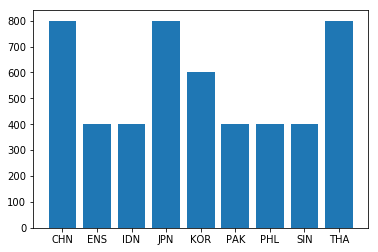

In [8]:
fig, ax = plt.subplots()
ax.bar(range(len(countries)), sample_count)
#ax.xticks = countries
plt.xticks(range(len(countries)), countries)
#fig.set_size_inches(18.5, 10.5, forward=True)
fig.show()

In [9]:
X = df_0['essay_content']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [10]:
vectorizer = TfidfVectorizer(lowercase=True)
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [11]:
X_train_dtm.shape

(2500, 11225)

In [37]:
clf = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)

In [38]:
#clf.coef_

In [39]:
accuracy_score(y_test, y_pred)

0.8468

In [59]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=900)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=5)
print scores

[ 0.80318091  0.80079681  0.8003992   0.80321285  0.82258065]


In [27]:
pipeline_mnb = Pipeline([
    ('vect', CountVectorizer(lowercase=True, max_features=900)),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_mnb, X_train, y_train, cv=5)
print scores

[ 0.8250497   0.83101392  0.85        0.82128514  0.83467742]


In [55]:
pipeline_rf = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=900)),
    ('clf', RandomForestClassifier(n_estimators=100))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=5)
print scores

[ 0.70178926  0.71115538  0.68463074  0.68072289  0.72782258]


In [60]:
pipeline_svm = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=900)),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_svm, X_train, y_train, cv=5)
print scores

[ 0.87077535  0.86454183  0.86826347  0.86746988  0.89314516]


# Feature Extraction

## Unique words after lemmatization

**I used lemmatization because unlike stemming, lemma considers linguistic meaning of a word, although it uses more resources and is slower**

In [12]:
df_0['unique_lemma'] = df_0['essay_content'].apply(lambda x: len(set([token.lemma_ for token in spc_nlp(x.decode('utf-8')) if token.is_punct==False])))

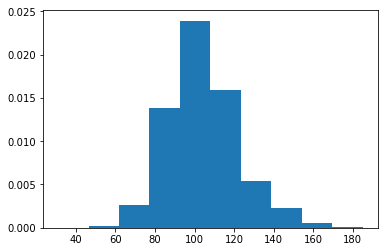

In [115]:
plt.hist(df_0['unique_lemma'], bins = 10, normed=1)
plt.show()

## Average Sentence Length

In [42]:
df_0['avg_stc_length'] = df_0['essay_content'].apply(lambda x: np.mean([len(s) for s in spc_nlp(x.decode('utf-8')).sents]))

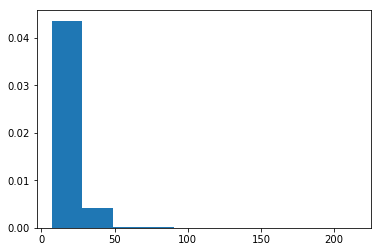

In [53]:
plt.hist(df_0['avg_stc_length'], bins = 10, normed=1)
plt.show()

## Total Sentence Count

In [14]:
#start = time()
df_0['total_stc'] = df_0['essay_content'].apply(lambda x: len([s for s in spc_nlp(x.decode('utf-8')).sents]))
#end = time()
#duration = end - start
#print duration

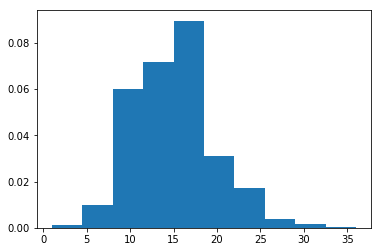

In [97]:
plt.hist(df_0['total_stc'], bins = 10, normed=1)
plt.show()

In [16]:
np.median(df_0['total_stc'])

15.0

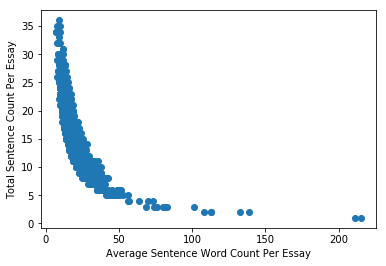

In [77]:
fig,ax = plt.subplots()
ax.scatter(df_0['avg_stc_length'], df_0['total_stc'])
ax.set_xlabel('Average Sentence Word Count Per Essay')
ax.set_ylabel('Total Sentence Count Per Essay')
plt.show()

**avg_stc_length and total_stc grow inversely**

In [79]:
df_ave_stc_40plus = df_0[df_0['avg_stc_length']>40]
df_ave_stc_40plus.groupby(['label']).size()

label
CHN     2
ENS     9
IDN     6
KOR     5
PAK     1
PHL     6
SIN     6
THA    22
dtype: int64

In [65]:
df_sent_less7 = df_0[df_0['total_stc']<7]
df_sent_less7.groupby(['label']).size()

label
CHN     1
ENS    34
IDN     6
KOR     6
PAK     1
PHL     7
SIN    10
THA    25
dtype: int64

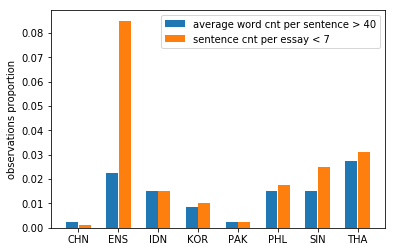

In [119]:
countries = list(df_ave_stc_40plus.groupby(['label']).size().index)
word_cnt = df_ave_stc_40plus.groupby(['label']).size().values
sent_cnt = df_sent_less7.groupby(['label']).size().values
essay_cnt_country = df_0[df_0['label']!='JPN'].groupby(['label']).size().values

fig, ax = plt.subplots()
ax.bar(np.arange(len(countries)), word_cnt*1./essay_cnt_country, 0.3, label='average word cnt per sentence > 40')
ax.bar(np.arange(len(countries))+0.32, sent_cnt*1./essay_cnt_country, 0.3, label='sentence cnt per essay < 7')
ax.set_ylabel('observations proportion')
plt.xticks(np.arange(len(countries))+0.16, countries)
#fig.set_size_inches(18.5, 10.5, forward=True)
ax.legend()
fig.show()

**The plot demonstrate that in native-speaker group, writers tend to write essays using less sentences while these sentences are not necessarilty long**